# Импорты и функции для обучения автоэнкодеров

In [ ]:
!pip install -q lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 44.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import lightning as L
from collections import defaultdict


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
def plot_manifold(latent_r, labels=None, alpha=0.9, classes=None, title=None):
    plt.figure(figsize=(8, 8))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], alpha=alpha)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        cbar = plt.colorbar()
    if classes:
        num_of_classes = list(range(0, len(classes)))
        cbar.ax.set_yticks(num_of_classes)
        cbar.ax.set_yticklabels(classes)
    if title:
        plt.title(title)
    plt.show()


# plotting reconstructed and noised images
def plot_samples(*args, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [ ]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256]  # num of filters in layers
        modules = []
        in_channels = 1  # initial value of channels
        for h_dim in hidden_dims:  # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,  # num of input channels
                        out_channels=h_dim,  # num of output channels
                        kernel_size=3,
                        stride=2,  # convolution kernel step
                        padding=1,  # save shape
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim  # changing number of input channels for next iteration


        modules.append(nn.Flatten())  # to vector, size 256 * 2 * 2 = 1024
        modules.append(nn.Linear(256 * 2 * 2, latent_dim))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [256, 128, 64, 32]  # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=1024)

        modules = []
        for i in range(len(hidden_dims) - 1):  # define upsample layers
            modules.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU()
                )
            )

        modules.append(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=hidden_dims[-1],
                          out_channels=1,
                          kernel_size=5)
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x, with_sigmoid=False):
        x = self.linear(x)  # from latents space to Linear
        x = x.view(-1, 256, 2, 2)  # reshape
        x = self.decoder(x)  # reconstruction
        if with_sigmoid:
            x = F.sigmoid(x)
        return x

In [ ]:
class LitAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)

        # here is the loss function computing
        loss = F.binary_cross_entropy_with_logits(recon, data)

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def on_test_epoch_start(self):
        # create dict with empty tensors for further accumulating over batches
        self.test_result = defaultdict(torch.Tensor)

    def test_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent, with_sigmoid=True)

        self.update_test_result(data, recon, latent, labels)

    def update_test_result(self, data, recon, latent, labels):
        # accumulating results every batch
        self.test_result["real"] = torch.cat([self.test_result["real"], data.cpu()])
        self.test_result["recon"] = torch.cat([self.test_result["recon"], recon.cpu()])
        self.test_result["latent"] = torch.cat([self.test_result["latent"], latent.cpu()])
        self.test_result["labels"] = torch.cat([self.test_result["labels"], labels.cpu()])

    def on_test_epoch_end(self):
        # simply change type from torch tensor to numpy array
        # for every item in test_result dictionary
        for key in self.test_result:
            self.test_result[key] = self.test_result[key].numpy()


# Задание 1. Автоэнкодер для FashionMNIST c MSE-loss

В этом задании требуется обучить автоэнкодер на датасете FashionMNIST.

* Используйте энкодер и декодер из лекции (код `Encoder`, `Decoder` выше).
* Замените функцию потерь при обучении автоэнкодера на MSE.
* Обучите автоэнкодер с размером латентного слоя 2.
* Выведите латентное представление объектов на плоскости. Проанализируйте, разделяются ли в нем классы?

Далее:

* Обучите автоэнкодер с размером латентного слоя 30.
* Продемонстрируйте восстановление автоэнкодером переданных ему изображений.

Напишите выводы.

**Подсказки:**

* Для обучения и тестирования воспользуйтесь Lightning-модулем `LitAE` (код выше). Для того, чтобы заменить функцию потерь, рекомендуется отнаследоваться от `LitAE` и переопределить метод `training_step`, заменив функцию потерь в нем.
* Также при использовании MSE нам не нужна сигмоида на выходе декодера как при обучении, так и при тестировании. Поэтому потребуется переопределить также и `test_step`, где в вызове декодера потребуется передать флаг `with_sigmoid=False`.
* Для визуализации латентных представлений на плоскости рекомендуется использовать функцию `plot_manifold` (код выше).
* Для визуализации оригинальных изображений и их реконструкций рекомендуется использовать функцию `plot_samples` (код выше).

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

root = "./data"

base = transforms.ToTensor()
train_set = FashionMNIST(root=root, train=True, transform=base, download=True)
test_set = FashionMNIST(root=root, train=False, transform=base, download=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:03<00:00, 8309164.58it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 142561.38it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2519216.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18874368.00it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



В датасете 10 классов, каждый соответствует одному из предметов гардероба.

In [ ]:
import numpy as np

# method for display all class samples from dataset


def show_dataset(dataset):
    fig, axs = plt.subplots(1, len(dataset.classes), figsize=(20, 5))
    for cls_num, name in enumerate(dataset.classes):
        i = np.argwhere(dataset.targets == cls_num)[0][0]
        ax = axs[cls_num]
        ax.imshow(dataset.data[i], cmap="gray_r")
        ax.set_title(name)
        ax.axis("off")
    plt.show()

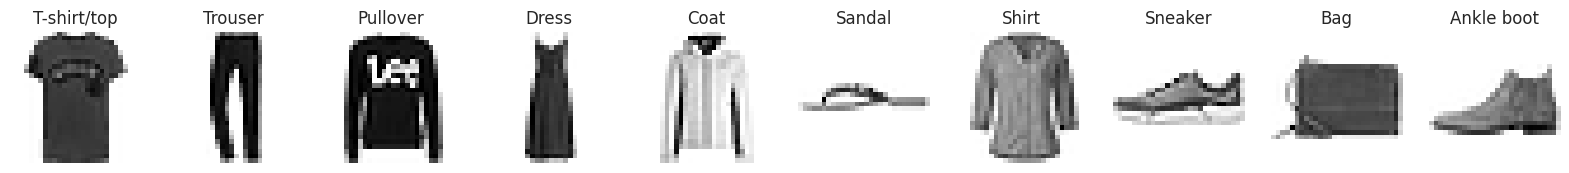

In [ ]:
show_dataset(test_set)

Задайте `latent_dim` равным 2 для последующего построения отображения латентных представлений на плоскости. Инициализируйте модели энкодера и декодера.

In [ ]:
L.seed_everything(42)

latent_dim = 2   # Your code here
encoder = Encoder(latent_dim=latent_dim) # Your code here
decoder = Decoder(latent_dim=latent_dim) # Your code here

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Опишите класс-наследник `LitAE`, который будет использовать [`mse_loss`](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html) в качестве функции потерь для автоэнкодера внутри `trainig_step`, а также будет использовать декодер без сигмоиды на выходе в `test_step`.

In [ ]:
class LitAE_with_MSE(LitAE):
    def training_step(self, batch, batch_idx):
        # Your code here
        data, labels = batch

        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)

        # here is the loss function computing
        loss = nn.functional.mse_loss(recon, data)

        self.log("train_loss", loss)
        return loss


    def test_step(self, batch, batch_idx):
        # Your code here
        data, labels = batch

        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent, with_sigmoid=False)

        self.update_test_result(data, recon, latent, labels)


Наконец, обучите автоэнкодер.

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

# Your code here
autoencoder = LitAE_with_MSE(encoder, decoder)

logger = TensorBoardLogger(save_dir="lightning_logs", name="AE_latent_dim=2")
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 390 K 
1 | decoder | Decoder | 391 K 
------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.130     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Для прогона тестовых данных через автоэнкодер воспользуйтесь `trainer.test`. Результат тестирования будет записан в словарь в атрибуте `.test_result` Lightning-модели автоэнкодера.

In [ ]:
# Your code here
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

Выведите латентное представление объектов на плоскости. Проанализируйте, разделяются ли в нем классы? Какие классы смешиваются, а какие хорошо отделяются?

У функции `plot_manifold` есть аргумент `classes`. В него можно передать список названий классов (`test_set.classes`) для отображения названий вместо номеров классов.

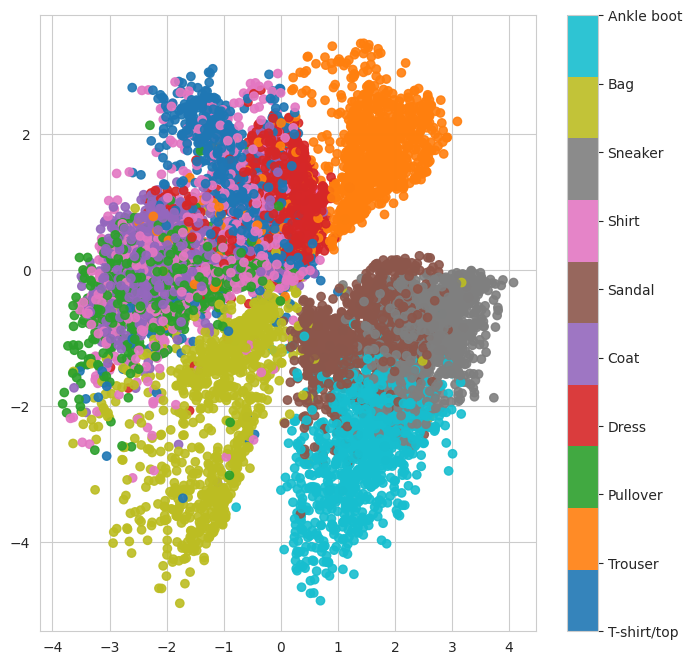

In [ ]:
# Your code here
plot_manifold(run_res["latent"], labels=run_res["labels"], alpha=0.9, classes=test_set.classes, title=None)

*Ваши наблюдения:*

Можно заметить, что в этом представлении можно выделить "кластеры", соответствующие типу одежды: кластер, где представлена одежда "на тело" - футболка, пуловер, платье, пальто, рубашка; кластер обуви - ботильоны, тапочки, кроссовки; отдельно выделяются класс сумок и класс штанов.

Чем более непохожие вещи внутри кластера, тем лучше они разделены. Например, модель довольно неплохо разделила обувь, но среди нательных вещей отдельно можно заметить только штаны, которые для нижней части тела.

Теперь обучите автоэнкодер с размером латентного слоя 30.

In [ ]:
# Your code here
latent_dim_30 = 30
encoder_30 = Encoder(latent_dim=latent_dim_30)
decoder_30 = Decoder(latent_dim=latent_dim_30)


autoencoder_30 = LitAE_with_MSE(encoder_30, decoder_30)

logger = TensorBoardLogger(save_dir="lightning_logs", name="AE_latent_dim=30")
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder_30, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 419 K 
1 | decoder | Decoder | 420 K 
------------------------------------
839 K     Trainable params
0         Non-trainable params
839 K     Total params
3.359     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Обработайте автоэнкодером тестовые данные. Продемонстрируйте восстановление автоэнкодером переданных ему изображений. Используйте функцию `plot_samples`.

In [ ]:
# Your code here
trainer.test(autoencoder_30, test_loader)
run_res_30 = autoencoder_30.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [ ]:
%tensorboard --logdir lightning_logs

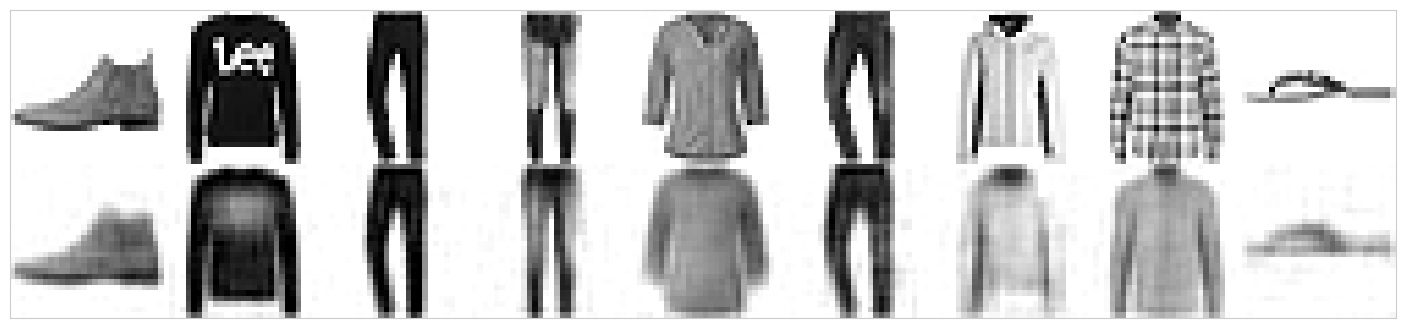

In [ ]:
plot_samples(run_res_30["real"][0:9], run_res_30["recon"][0:9])

Какие особенности в востановленных изображениях по сравнению с исходными вы можете отметить?

*Ваши наблюдения:*

***Your text here***

Изображения получились более размытые, и содержат меньше информации, чем исходные (на кофте уже нельзя различить надпись, на рубашке - узор). Но это и понятно, ведь мы сознательно передали эти изображения в энкодер, после чего в скрытом представлении была потеряна информация.

Также можно отметить, что автоэнкодер с размером латентного слоя 30 учится быстрее и лучше, чем с размером латентного слоя 2.

## Формат результата

1. Визуализация латентного пространства для автоэнкодера с `latent_dim=2`, **выводы**. Пример визуализации:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/result_1_1_task_ex12.png" width="500"/>


2. Изображения, восстановленные автоэнкодером c `latent_dim=30`, **выводы**. Пример изображений:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/result_2_1_task_ex12.png" width="500"/>



# Задание 2. Обнаружение аномалий с помощью автоэнкодера

Представим следующую ситуацию: нам нужна система, которая принимает изображение сетчатки глаза. Если изображение не является фотографией сетчатки глаза, то система должна сообщить пользователю об ошибке и не принимать это изображение.

Идея заключается в следующем: если автоэнкодер может выучить внутреннее представление данных, например, фотографий сетчатки глаза, то при восстановлении данных, которые не являются фотографией сетчатки глаза, ошибка будет существенно больше. Установив порог этой ошибки, мы сможем отделять нужные фотографии от ненужных.


*   Обучите автоэнкодер на фотографиях сетчатки глаза (RetinaMNIST)
*   Подайте в автоэнкодер другое изображение (здесь будет использован BloodMNIST)
*   Посчитайте ошибку восстановления для разных датасетов
*   Установите порог (значение ошибки) для определения класса фотографии (сетчатка глаза или нет)
*   Проведите тесты
*   Напишите выводы

[MedMNIST](https://medmnist.com/) — это набор медицинских датасетов, по формату повторяющих MNIST:

* размер изображений 28×28
* совместимы с PyTorch ([пример использования](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb))

Для начала работы необходимо установить соответствующий пакет:


In [ ]:
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


В этом задании будем работать с двумя датасетами:

[RetinaMNIST](https://isbi.deepdr.org/data.html) и [BloodMNIST](https://www.researchgate.net/publication/340522931_A_dataset_of_microscopic_peripheral_blood_cell_images_for_development_of_automatic_recognition_systems)

Первый содержит изображения сетчатки глаз, второй — клеток крови.

100%|██████████| 3291041/3291041 [00:01<00:00, 2184684.33it/s]


Using downloaded and verified file: /root/.medmnist/retinamnist.npz


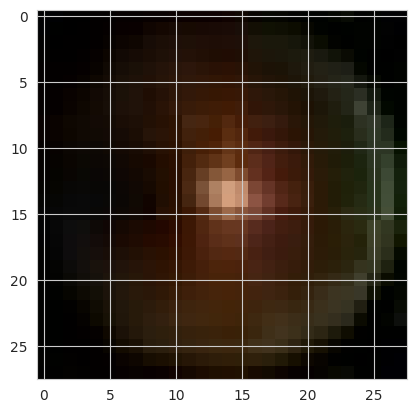

In [ ]:
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

DataClass = getattr(medmnist, INFO["retinamnist"]["python_class"])

train_retina_dataset = DataClass(split="train", download=True)
val_retina_dataset = DataClass(split="val", download=True)

plt.imshow(val_retina_dataset[0][0])
plt.show()

Несмотря на заявленную совместимость с PyTorch, у датасетов нет свойств `targets` и `data`.

Но есть словарь `info`

[Код](https://github.com/MedMNIST/MedMNIST/blob/main/medmnist/dataset.py)

In [ ]:
info = val_retina_dataset.info
info

{'python_class': 'RetinaMNIST',
 'description': 'The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/retinamnist.npz?download=1',
 'MD5': 'bd4c0672f1bba3e3a89f0e4e876791e4',
 'url_64': 'https://zenodo.org/records/10519652/files/retinamnist_64.npz?download=1',
 'MD5_64': 'afda852cc34dcda56f86ad2b2457dbcc',
 'url_128': 'https://zenodo.org/records/10519652/files/retinamnist_128.npz?download=1',
 'MD5_128': 'e48e916a24454daf90583d4e6efb1a18',
 'url_224': 'https://zenodo.org/records/10519652/files/retinamnist_224.npz?download=1',
 'MD5_224': 'eae7e3b6f3fcbda4ae613ebdcbe35348',
 'task': 

В нем есть аналогичное `targets` свойство `labels`, а у самого объекта есть массив `imgs`, аналогичный `data` в torchvision датасетах.

In [ ]:
print("labels", val_retina_dataset.labels.shape)
print("images", val_retina_dataset.imgs.shape)

labels (120, 1)
images (120, 28, 28, 3)


Используя эти свойства, можно сделать датасет совместимым с нашим кодом, написанным для MNIST:

In [ ]:
def cast2torch(ds):
    ds.targets = ds.labels
    ds.data = ds.imgs
    ds.classes = list(info["label"].values())


cast2torch(val_retina_dataset)
cast2torch(train_retina_dataset)

**RetinaMNIST classes**

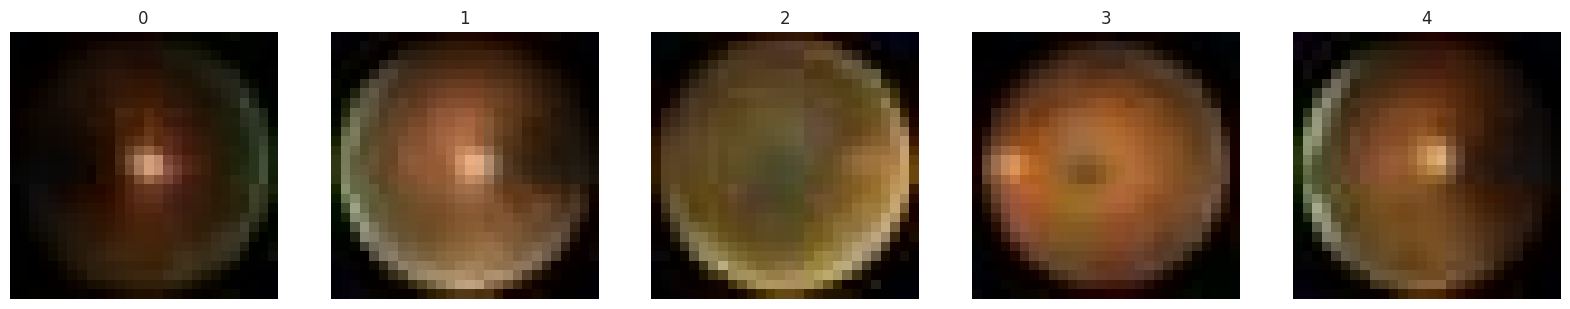

In [ ]:
show_dataset(val_retina_dataset)

Названий классов тут нет, но для нашей задачи они нам и не понадобятся.
Теперь загрузим датасет с клетками крови

In [ ]:
DataClass = getattr(medmnist, INFO["bloodmnist"]["python_class"])
test_blood_dataset = DataClass(split="test", download=True)
cast2torch(test_blood_dataset)

100%|██████████| 35461855/35461855 [00:04<00:00, 8144119.66it/s] 


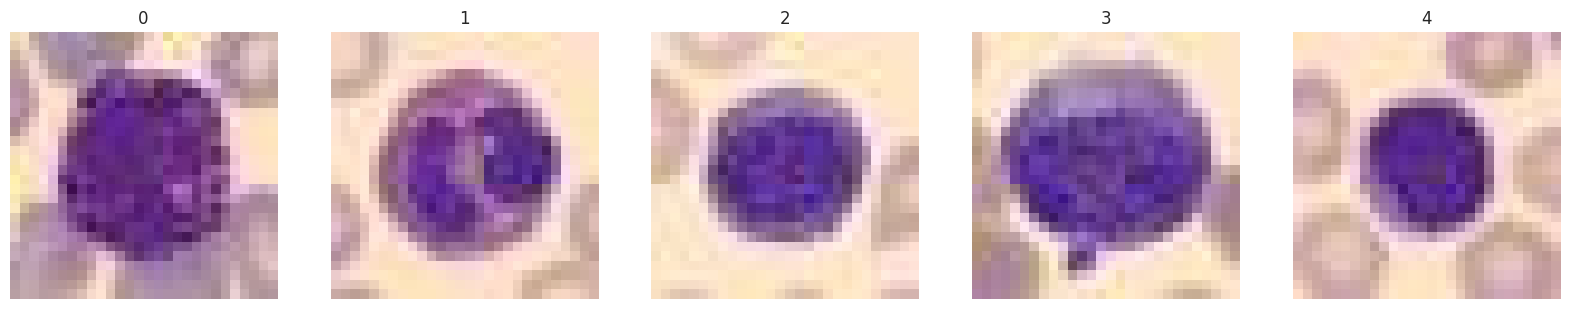

In [ ]:
show_dataset(test_blood_dataset)

По форме клетки крови отдаленно напоминают фото сетчатки.

Представим, что при сборе новой порции данных фотографии клеток крови по ошибке попали в папку с фото сетчатки и были включены в новую версию датасета.

Нам надо исправить ошибку и отделить фото клеток сетчатки от фото клеток крови.

Для этого обучим автоэнкодер на той части датасета, которая была собрана раньше и не содержит ошибок. Будем считать, что это `train_retina_dataset`.

Обучим на них автоэнкодер. Для этого создадим загрузчики и добавим трансформации к датасетам. В частности, сделаем изображения черно-белыми, чтобы использовать пайплайн из предыдущего задания.

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


data_transform = transforms.Compose(
    [
        # Convert all images to Grayscale for sake of MNIST compatibility
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

train_retina_dataset.transform = data_transform
val_retina_dataset.transform = data_transform
test_blood_dataset.transform = data_transform

# encapsulate data into dataloader form
train_loader = DataLoader(
    train_retina_dataset, batch_size=128, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_retina_dataset, batch_size=1, shuffle=False, num_workers=2)
blood_loader = DataLoader(
    test_blood_dataset, batch_size=1, shuffle=False, num_workers=2
)

Создайте энкодер и декодер (`latent_dim=2`) и обучите AE 15–30 эпох (занимает несколько секунд).

Можно пользоваться `LitAE`, в котором в качестве функции потерь используется бинарная кросс-энтропия, а можно `LitAE_with_MSE`.

In [ ]:
# Your code here
latent_dim_anomaly = 2
encoder_anomaly = Encoder(latent_dim=latent_dim_anomaly)
decoder_anomaly = Decoder(latent_dim=latent_dim_anomaly)


autoencoder_anomaly = LitAE_with_MSE(encoder_anomaly, decoder_anomaly)

logger = TensorBoardLogger(save_dir="lightning_logs_2", name="AE_latent_dim_anomaly")
trainer = L.Trainer(max_epochs=30, logger=logger)

trainer.fit(autoencoder_anomaly, train_loader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 390 K 
1 | decoder | Decoder | 391 K 
------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.130     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Typ

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
%tensorboard --logdir lightning_logs_2

Посмотрим, как автоэнкодер научился восстанавливать изображения сетчатки, на которых его учили:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

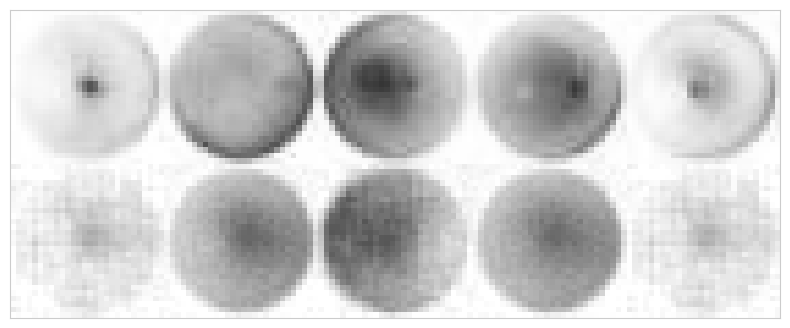

MSE for correct retina images 0.005341092


In [ ]:
from sklearn.metrics import mean_squared_error


def get_mse_and_show_results(dataloader):
    trainer.test(autoencoder_anomaly, dataloader)
    run_res = autoencoder_anomaly.test_result

    real = run_res["real"]
    recon = run_res["recon"]

    cnt = len(real)
    mse = mean_squared_error(
        real.reshape(cnt, -1), recon.reshape(cnt, -1), multioutput="raw_values"
    )

    plot_samples(real[0:5], recon[0:5])
    return mse


mse_retina = get_mse_and_show_results(val_loader)
print("MSE for correct retina images", mse_retina.mean())

Теперь посмотрим, что будет, если попытаться восстановить изображения клеток крови:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

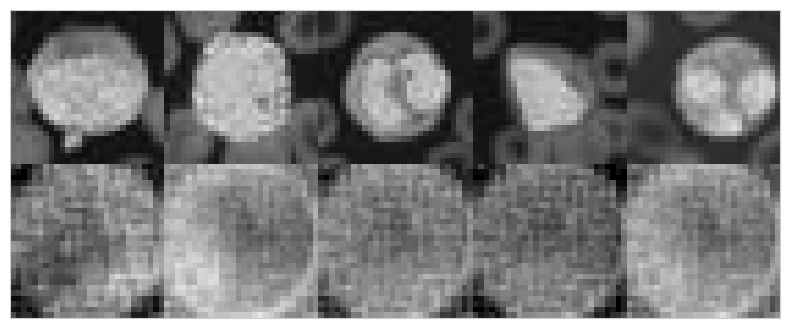

MSE for blood cell images 0.07755857


In [ ]:
mse_blood = get_mse_and_show_results(blood_loader)
print("MSE for blood cell images", mse_blood.mean())

Видно, что автоэнкодер пытается восстанавливать фотографии сетчатки и ошибка на порядок больше. Можно разделить фотографии по значению ошибки восстановления.

В качестве "испорченного датасета" возьмем `val` чаcть из RetinaMnist и `test` часть из BloodMnist.

Постройте гистограммы ошибок `mse_retina` и `mse_blood`:

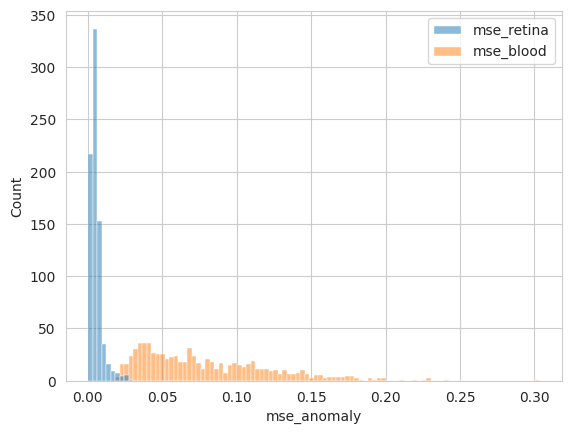

In [ ]:
# Your code here
import seaborn as sns

mse_anomaly = {"mse_retina": mse_retina, "mse_blood": mse_blood}

ax = sns.histplot(mse_anomaly, bins=100)
ax.set(xlabel="mse_anomaly")
plt.show()

Выберите порог ошибки восстановления и вычислите метрики качества отделения снимков сетчатки от снимков крови: accuracy, precision, recall, f1-score.

In [ ]:
threshold = 0.025

In [ ]:
y_true = [1] * 784 + [0] * 784
len(y_true)

1568

In [ ]:
y_pred = []
y_temp = np.concatenate([mse_retina, mse_blood])
for _ in y_temp:
    if _ <= threshold:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       784
           1       0.97      0.99      0.98       784

    accuracy                           0.98      1568
   macro avg       0.98      0.98      0.98      1568
weighted avg       0.98      0.98      0.98      1568



## Формат результата

Метрики качества отделения снимков сетчатки от снимков крови: accuracy, precision, recall, f1-score — не менее 0.95.

**Вывод: обученный на определенных данных автоэнкодер позволяет обнаруживать аномалии при восстановлении изображений, если подать ему другие данные. Разделить данные можно по выбранному порогу для ошибки восстановления.**

# Задание 3. Сэмплирование из VAE

Задача:
 1. Обучить VAE из лекции (`latent_dim = 2`) на датасете MNIST.
 2. Визуализировать латентные представления, которые приходят на вход декодера. Для этого можно воспользоваться функцией `plot_manifold`. Чтобы точки на полученном графике не полностью перекрывались, используйте параметр `alpha` из `sns.scatterplot` или `plot_manifold` (код выше).

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

root = "./data"

train_set = MNIST(
    root=root, train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_set = MNIST(
    root=root, train=False, transform=torchvision.transforms.ToTensor(), download=True
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=False, num_workers=2
)

100%|██████████| 9912422/9912422 [00:00<00:00, 87477168.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22795576.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24450997.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6682051.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0:  # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")

        super().__init__(latent_dim)

In [ ]:
import lightning as L
import torch.nn.functional as F


class LitVAE(LitAE):
    def __init__(self, encoder, decoder, kld_weight=0.005, recon_weight=1.0):
        super().__init__(encoder, decoder)
        self.kld_weight = kld_weight
        self.recon_weight = recon_weight

    def vae_split(self, latent):
        size = latent.shape[1] // 2  # divide the latent representation into mu and log_var
        mu = latent[:, :size]
        log_var = latent[:, size:]
        return mu, log_var

    def vae_reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn(mu.shape[0], mu.shape[1]).to(self.device)
        return eps * sigma + mu

    def kld_loss(self, mu, log_var):
        var = log_var.exp()
        kl_loss = torch.mean(-0.5 * torch.sum(log_var - var - mu**2 + 1, dim=1), dim=0)
        return kl_loss

    def training_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through VAE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample)

        # here is the loss function computing
        loss = self.recon_weight * F.binary_cross_entropy_with_logits(recon, data) + \
               self.kld_weight * self.kld_loss(mu, log_var)

        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through VAE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample, with_sigmoid=True)

        self.update_test_result(data, recon, latent, labels)

Определите энкодер и декодер для VAE с `latent_dim=2`. Обратите внимание, что **энкодер должен выдавать вектор в два раза больший, чем `latent_dim`**, чтобы разделить его компоненты на две части: вектор средних и вектор стандартных отклонений.

Обучите VAE в течение 5 эпох.

In [ ]:
L.seed_everything(42)

latent_dim_vae = 2
encoder_vae = VAEEncoder(latent_dim=latent_dim_vae * 2)
decoder_vae = Decoder(latent_dim=latent_dim_vae)

autoencoder_vae = LitVAE(encoder_vae, decoder_vae, kld_weight=0.005, recon_weight=1.0)

logger = TensorBoardLogger(save_dir="lightning_logs", name="VAE_latent_dim=2_vae")
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder_vae, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | VAEEncoder | 392 K 
1 | decoder | Decoder    | 391 K 
---------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.138     Total estimated 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Обработайте тестовые данные с помощью обученного VAE.

In [ ]:
# Your code here
trainer.test(autoencoder_vae, test_loader)
run_res_vae = autoencoder_vae.test_result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Разделите латентное представление на выходе энкодера на `mu` и `log_var` (метод `vae_split`).

Сделайте reparametrization trick с `mu` и `log_var` и получите массив `sample` — в нем будут значения, которые приходят на вход декодеру (метод `vae_reparametrize`).

In [ ]:
# Your code here
mu, log_var = autoencoder_vae.vae_split(run_res_vae["latent"])

mu, log_var = torch.tensor(mu), torch.tensor(log_var)
sample = autoencoder_vae.vae_reparametrize(mu, log_var).numpy()

Визуализируем точки на входе в декодер.

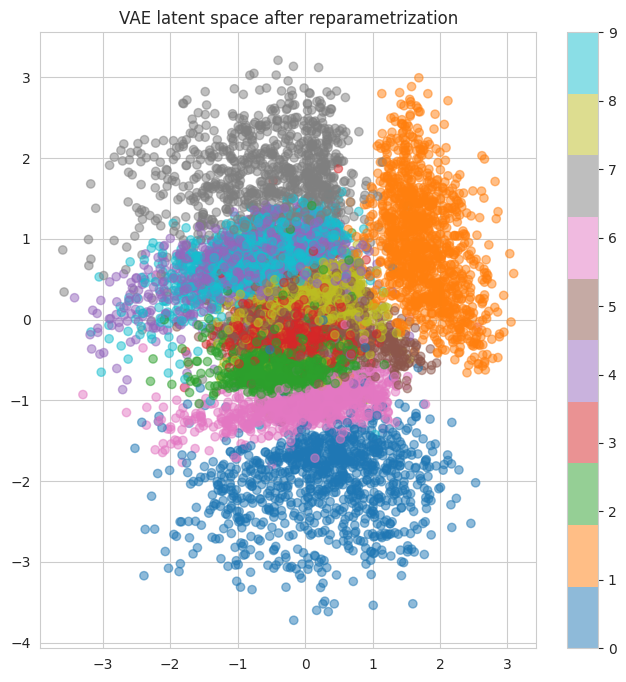

In [ ]:
plot_manifold(
    sample,
    run_res_vae["labels"],
    alpha=0.5,
    title="VAE latent space after reparametrization",
)

Здесь, как и в лекции, мы визуализировали латентные представления на входе декодера, обработав каждый объект тестовой выборки лишь один раз. Из-за этого один объект переводится в одну точку в латентном пространстве.

Однако при работе с VAE в латентном пространстве происходит случайное сэмплирование. Поэтому от запуска к запуску один и тот же объект переводится в немного отличающиеся латентные представления. За счет этого декодер получает на вход данные, более полно и вариативно покрывающие латентное пространство. Давайте в этом убедимся.

Выполните шаги для построения графика выше в цикле 10 раз.

In [ ]:
total_samples, total_labels = [], []

for _ in range(10):
    # 1. process test data with VAE
    # Your code here
    trainer.test(autoencoder_vae, test_loader)
    run_res_vae = autoencoder_vae.test_result

    # 2. do vae_split and vae_reparametrize
    # Your code here
    mu, log_var = autoencoder_vae.vae_split(run_res_vae["latent"])

    mu, log_var = torch.tensor(mu), torch.tensor(log_var)
    sample = autoencoder_vae.vae_reparametrize(mu, log_var).numpy()

    # 3. accumulate results over several runs, nothing to add here
    total_samples.append(sample)
    total_labels.append(run_res_vae["labels"])

total_samples = np.vstack(total_samples)
total_labels = np.vstack(total_labels)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Визуализируем точки на входе в декодер.

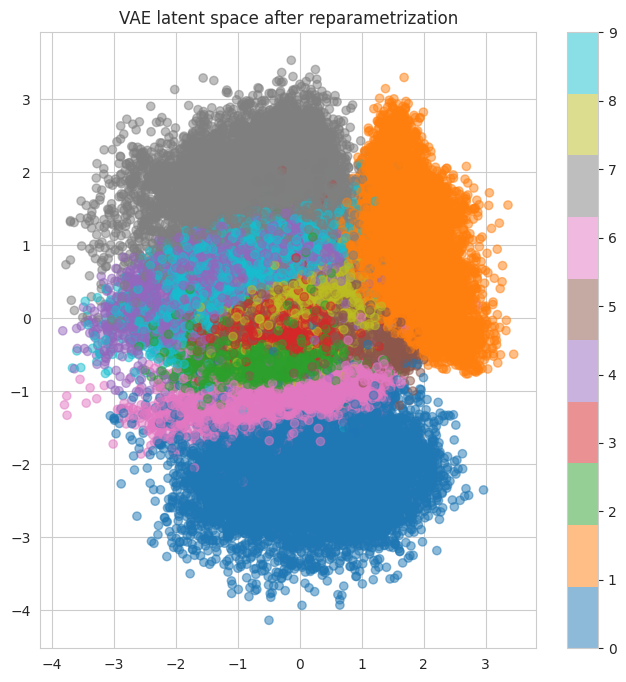

In [ ]:
plot_manifold(
    total_samples,
    total_labels,
    alpha=0.5,
    title="VAE latent space after reparametrization",
)

##  Визуализация латентного пространства

Для VAE можно "погулять" по латентному пространству и посэмлировать объекты из разных областей. Таким образом можно получить распределение цифр на плоскости, вроде такого:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/vae_sampling.png" width="500">

Вашей задачей будет получить похожее изображение, используя только что обученный декодер от VAE. Используйте побольше изображений в каждом ряду (скажем, 50). Иначе все цифры можете не увидеть.

То, как задать в латентном пространстве сетку (grid) и произвести сэмплирование по сетке, см. в разделе "Генерация заданных цифр из латентного распределения" в лекции.

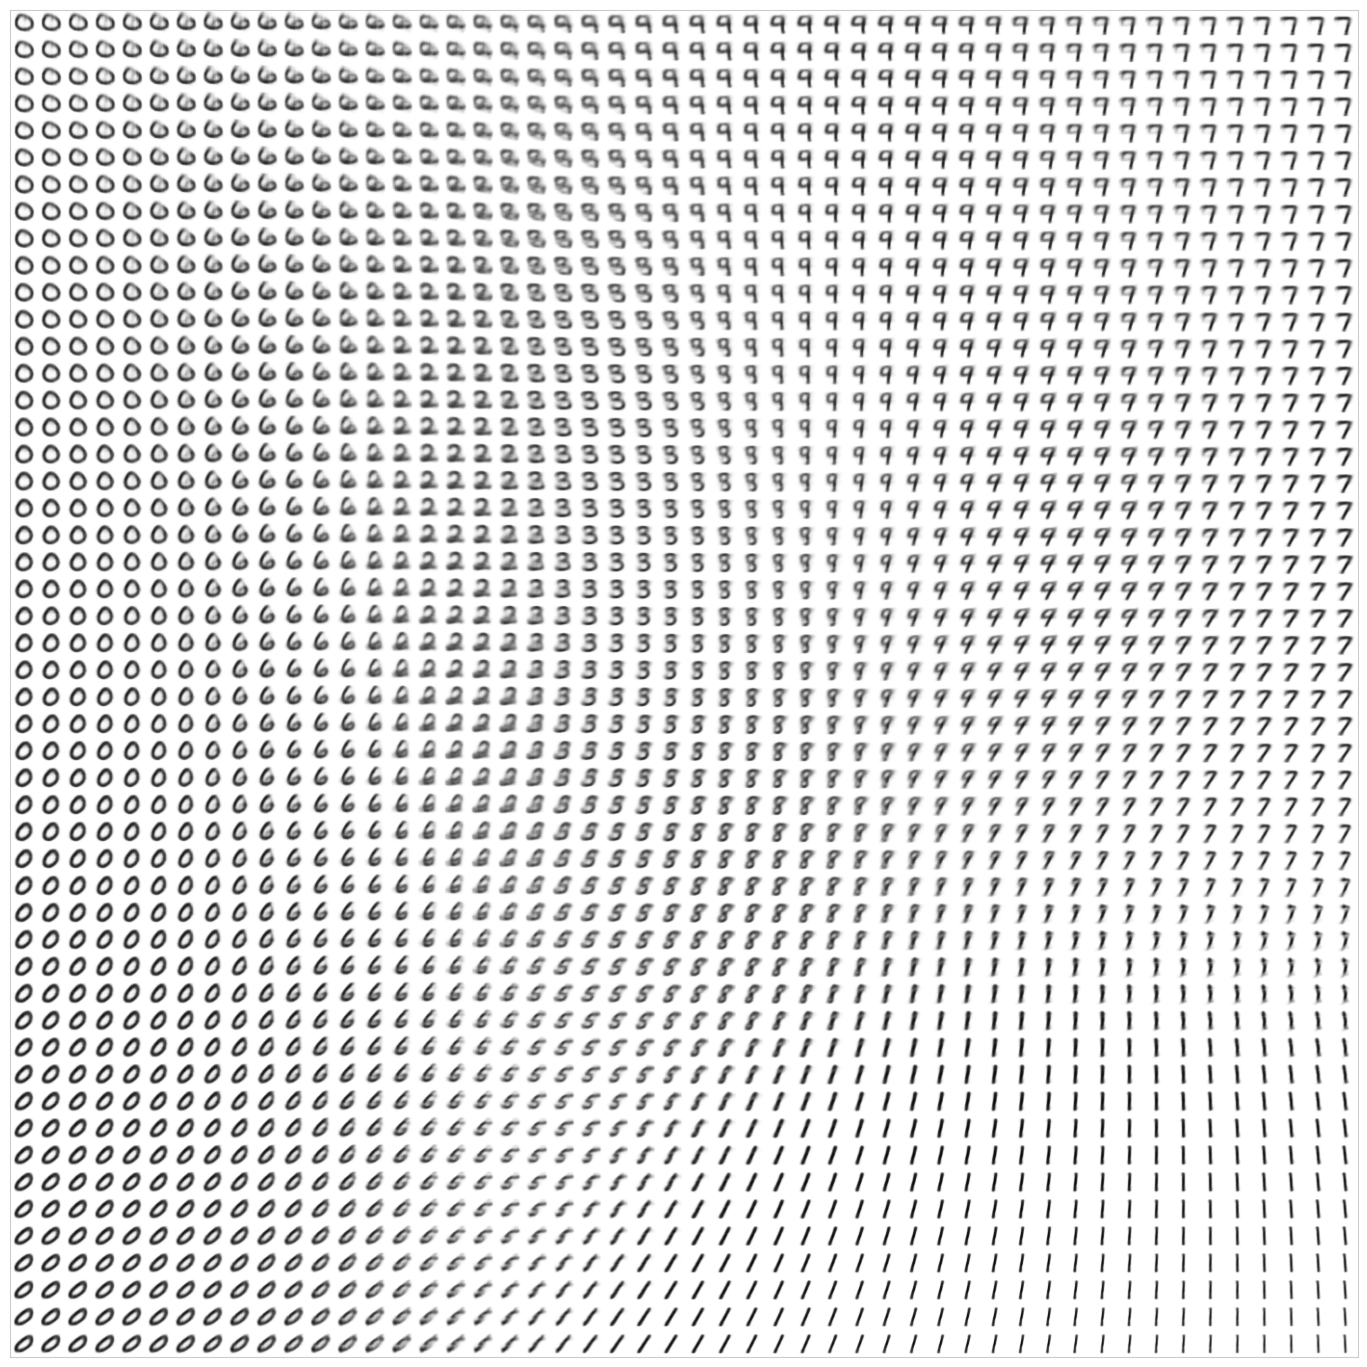

In [ ]:
steps = 50  # number of images in a row

# Your code here
space1 = torch.linspace(-2, 2, steps)
space2 = torch.linspace(-2, 2, steps)
grid = torch.cartesian_prod(space1, space2)
label = torch.full((grid.shape[0],), 4)
with torch.no_grad():
    imgs = autoencoder_vae.decoder(grid, with_sigmoid=True)
    imgs = imgs.cpu().numpy().squeeze()

plot_samples(
    *[imgs[x : x + steps] for x in range(0, steps * steps, steps)], single_size=0.35
)

## Формат результата

1. Визуализация латентных представлений, которые приходят на вход в `decoder`. Пример визуализации:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/result_1_3_task_ex12.png" width="500"/>

2. Результат сэмплирования из латентного пространства по равномерной сетке. Пример визуализации:

<img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/result_2_3_task_ex12.png" width="500"/>

**Вывод: для того, чтобы улучшить данные на входе в декодер, нужно проводить семплирование несколько раз, тогда у нас будет более полное покрытие латентного пространства.**

# Задание 4. Перенос стиля при помощи CVAE

С помощью CVAE можно решать задачу переноса стиля. Посмотрите на результат переноса стиля нескольких разных семерок на другие цифры:



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/style_transfer.png" width="500">

Ваша задача:
- Обучите CVAE, как в лекции (`latent_dim=2...10`). Вам понадобится условный декодер `CDecoder` и `LitCVAE`.

- Возьмите 10 случайных троек из тестового датасета и реализуйте перенос стиля троек на другие цифры.

- Выведите визуализацию, как в примере. На вашей визуализации тройки должны быть исходные, а остальные цифры — полученные в результате переноса стиля.

1. Воспользуйтесь кодом для `CDecoder` и `LitCVAE` из лекции, чтобы обучить свой CVAE. В качестве энкодера используйте `VAEEncoder`. Достаточно обучать 5 эпох.

In [ ]:
# Your code here
class LitCVAE(LitVAE):
    def training_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through CVAE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample, labels)  # decoder takes latent vector and class label

        # here is the loss function computing
        loss = self.recon_weight * F.binary_cross_entropy_with_logits(recon, data) + \
               self.kld_weight * self.kld_loss(mu, log_var)

        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        data, labels = batch

        # here is the logic how data is moved through CVAE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        # decoder takes latent vector and class label
        recon = self.decoder(sample, labels, with_sigmoid=True)

        self.update_test_result(data, recon, latent, labels)

In [ ]:
class CDecoder(Decoder):
    def __init__(self, latent_dim, class_dim):
        super().__init__(latent_dim)

        self.label_embedding = nn.Embedding(
            num_embeddings=10,
            embedding_dim=class_dim
        )

        linear_out_features = self.linear.out_features

        self.linear = nn.Linear(
            in_features=latent_dim+class_dim,  # linear will take latent vector concatenated with label embedding
            out_features=linear_out_features,
        )

    def forward(self, x, label, with_sigmoid=False):
        label = self.label_embedding(label)
        x = torch.cat([x, label], dim=1)  # concatenate latent vector and label embedding
        x = self.linear(x)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        if with_sigmoid:
            x = F.sigmoid(x)
        return x

In [ ]:
L.seed_everything(42)

latent_dim_cvae = 2
class_dim_cvae = 4
encoder_cvae = VAEEncoder(latent_dim=latent_dim_cvae * 2)
decoder_cvae = CDecoder(latent_dim=latent_dim_cvae, class_dim=class_dim_cvae)

autoencoder_cvae = LitCVAE(encoder_cvae, decoder_cvae)

logger = TensorBoardLogger(save_dir="lightning_logs", name="CVAE_latent_dim=2")
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder_cvae, train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | VAEEncoder | 392 K 
1 | decoder | CDecoder   | 395 K 
---------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.155     Total estimated 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


2. Обработайте тестовые данные с помощью CVAE.

In [ ]:
# Your code here
trainer.test(autoencoder_cvae, test_loader)
run_res_cvae = autoencoder_cvae.test_result


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

3. Из словаря, полученного в результате обработки тестовых данных, отберите 10 случайных троек (вам помогут ключи `"labels"` и `"real"`). Выведите их с помощью функции `plot_samples`.

In [ ]:
run_res_cvae.keys()

dict_keys(['real', 'recon', 'latent', 'labels'])

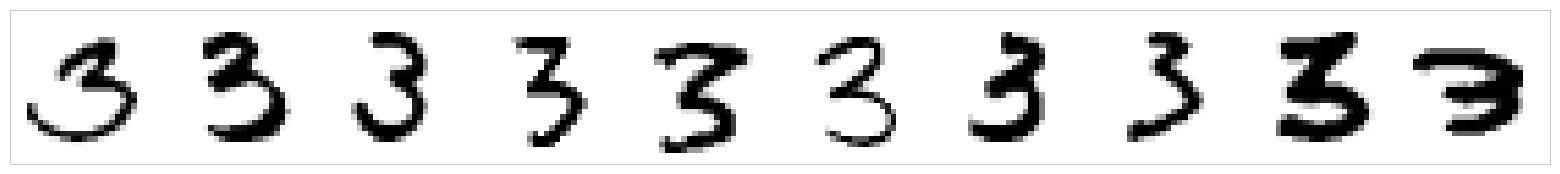

In [ ]:
# Your code here
plot_samples(run_res_cvae["real"][np.random.choice(np.where(run_res_cvae['labels'] == 3)[0], 10)])

4. Теперь вам нужно обработать ваши тройки **энкодером** и получить для них латентные представления, кодирующие стиль начертания. Далее в цикле по $i$ от 0 до 9 подать в декодер латентные представления ваших троек и метку $i$-той цифры.

Подсказка: вне цикла создайте пустой список `images`, а в цикле добавляйте в него результат работы декодера с $i$-той цифрой.

In [ ]:
indexes = np.random.choice(np.where(run_res_cvae['labels'] == 3)[0], 10)

In [ ]:
run_real_3 = run_res_cvae["real"][indexes]

In [ ]:
torch.from_numpy(run_real_3)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [ ]:
latent_space = autoencoder_cvae.encoder(torch.from_numpy(run_real_3))

In [ ]:
latent_space

tensor([[ 0.9260, -0.6418, -3.0344, -3.5985],
        [ 0.3053, -1.4691, -2.4997, -3.0257],
        [ 1.5559, -1.2561, -3.1089, -3.4096],
        [-0.3883,  0.4248, -2.7128, -3.3308],
        [-1.6350, -0.5687, -2.3845, -2.8595],
        [ 0.3850, -0.6927, -2.8227, -3.5231],
        [ 0.2770, -0.8989, -2.6089, -2.9446],
        [-0.0454, -0.8692, -3.0769, -3.4230],
        [ 0.3686, -0.4880, -3.1273, -3.4473],
        [-1.0344,  0.1313, -2.3393, -3.1812]], grad_fn=<AddmmBackward0>)

In [ ]:
mu, log_var = autoencoder_cvae.vae_split(latent_space)

mu, log_var = torch.tensor(mu), torch.tensor(log_var)
sample = autoencoder_cvae.vae_reparametrize(mu, log_var)

<ipython-input-60-470f9f7cc3ea>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu, log_var = torch.tensor(mu), torch.tensor(log_var)


In [ ]:
# Your code here
images = []
for i in range(10):
    if i == 3:
        images.append(run_real_3)
    else:
        images.append(autoencoder_cvae.decoder(sample, torch.tensor([i] * 10), with_sigmoid=True).detach())

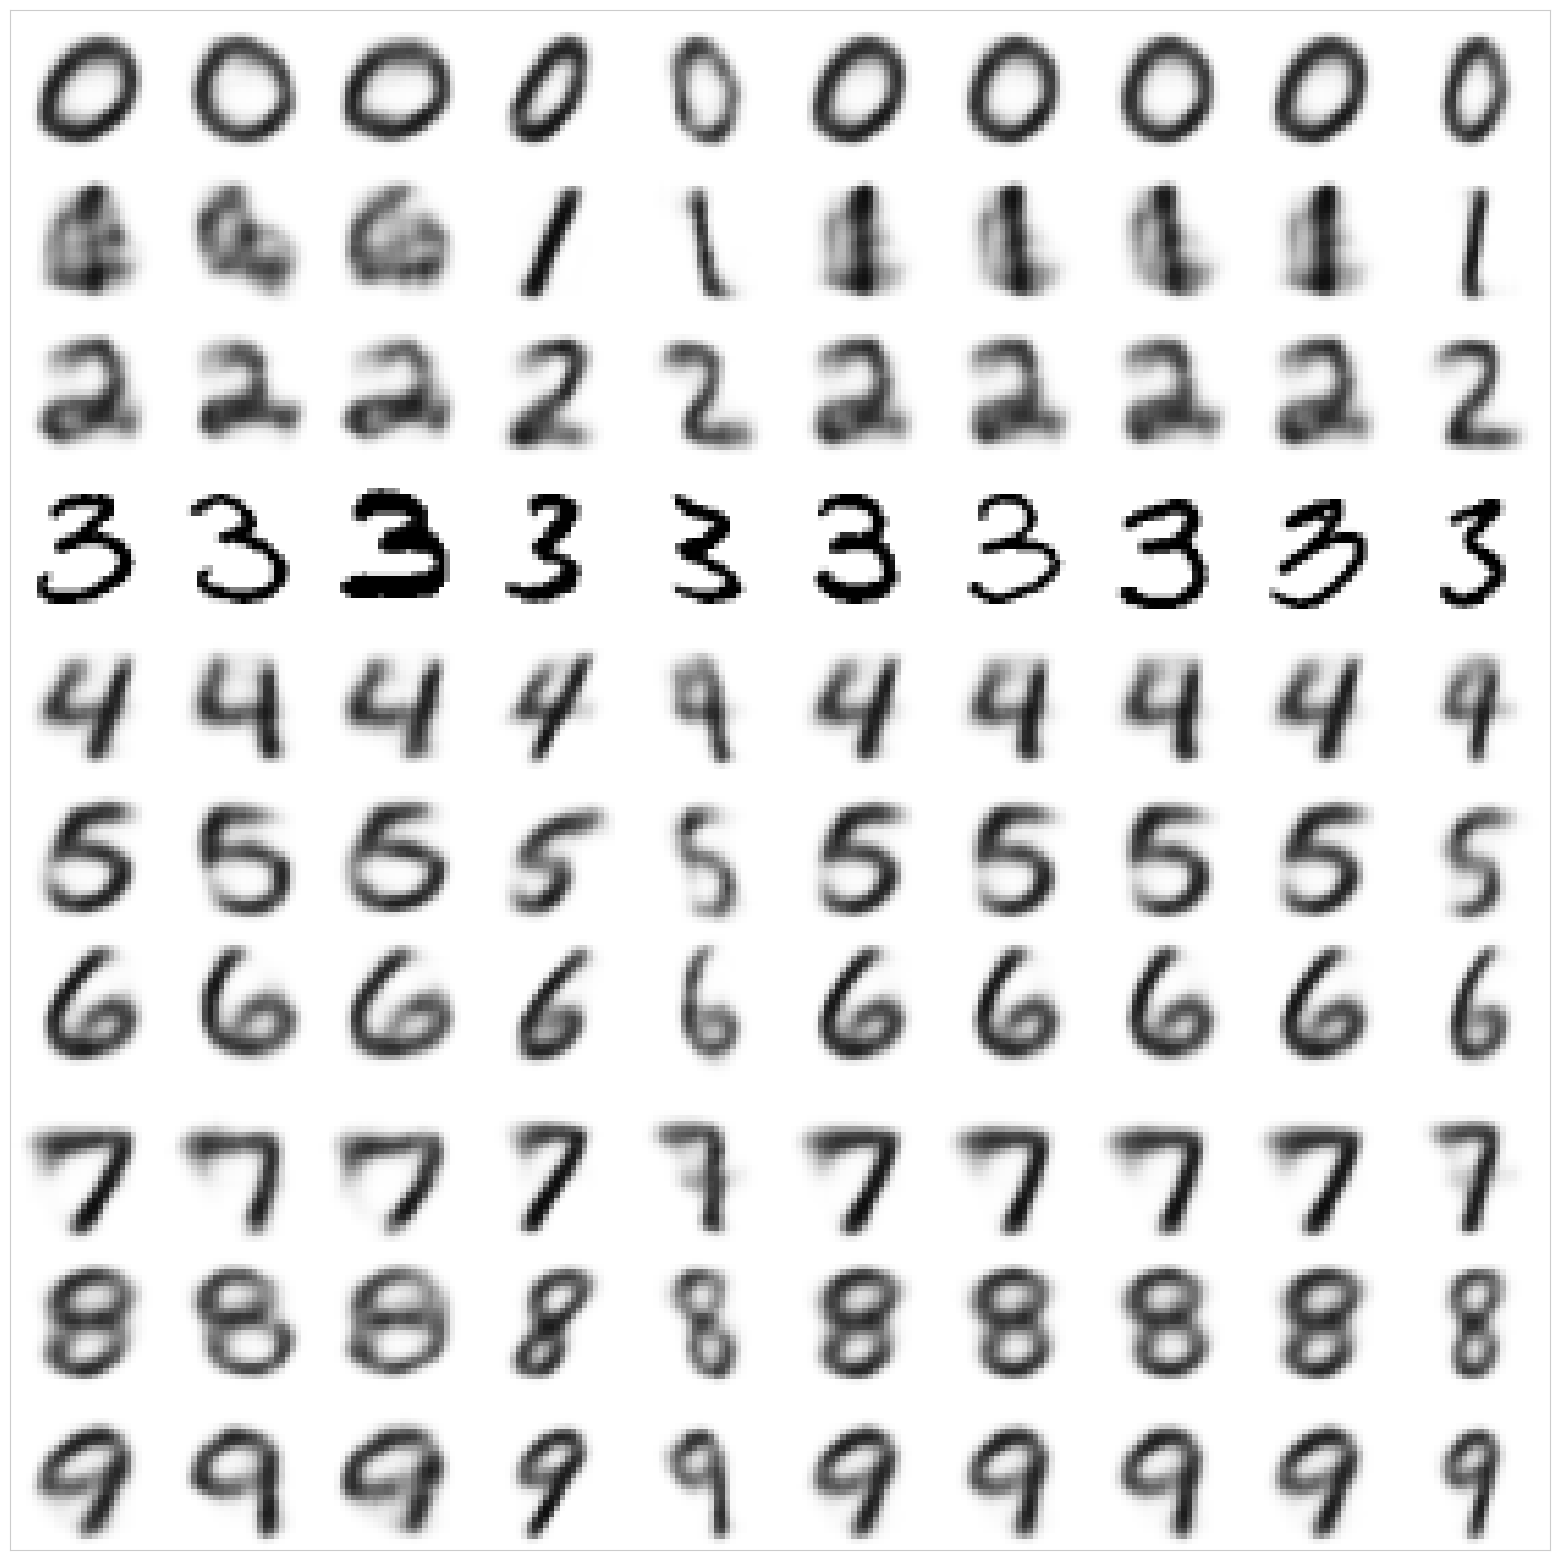

In [ ]:
plot_samples(*images)  # result

## Формат результата

Перенести стили троек на другие цифры. При этом сами тройки должны вывестись исходные.

Пример результата:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/result_4_task_ex12.png" width="500">

**Вывод: при помощи условного вариационного автоэнкодера можно осуществлять перенос стиля, используя латентное представление образца.**

# Задание 5. Сиамская сеть

С помощью сиамской сети решим задачу с Kaggle. Цель: обучить сиамскую модель отличать поддельные подписи:

[kaggle signature verification dataset](https://www.kaggle.com/robinreni/signature-verification-dataset)



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX12/signature_verification_dataset.png" width="600">

Датасет состоит из набора сканов подписей, разложенных по папкам согласно следующей структуре:

```
sign_data_mini/
├── train
|   ├── 001
|   |   ├── 001_01.PNG
|   |   ├ ...
|   |   └── 001_24.PNG
|   ├── 001_forg
|   |   └── ...
|   ├ ...
|   ├── 030
|   |   └── ...
|   └── 030_forg
|       └── ...
└── test
    ├── 049
    |   └── ...
    |
    ├── 049_forg
    |   └── ...
    ├ ...
    ├── 051
    |   └── ...
    └── 051_forg
        └── ...

```



В папке `id1` содержатся сканы подлинных подписей одного человека. В папке `id1_forg` содержатся сканы поддельных подписей того же человека.

В папках с перфиксом `id2`, `id2_forg` — настоящие и поддельные подписи другого человека и т. д.

В папке `train` собраны оригинальные и поддельные подписи тридцати человек (`id = 001 ... 030`), а в папке `test` — оригинальные и поддельные подписи трех человек, отличных от тридцати "обучающих" (`id = 049 ... 051`).

## Импорт библиотек

In [ ]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

## Загрузка датасета

Фрагмент датасета, достаточный для выполнения задания, доступен [по ссылке](https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/sign_mini.zip).


In [ ]:
!wget -N https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/sign_mini.zip
!unzip -qn sign_mini.zip

--2024-01-28 16:01:11--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/sign_mini.zip
Resolving edunet.kea.su (edunet.kea.su)... 51.158.190.138
Connecting to edunet.kea.su (edunet.kea.su)|51.158.190.138|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘sign_mini.zip’ not modified on server. Omitting download.



Класс датасета дан готовым.


В отличие от датасетов для классификации, метод `__getitem__` возвращает кортеж не из двух, а из трех элементов:.

1. Реальная подпись, соответствующая индексу `index`.
2. Подпись, с которой ее нужно сравнить. С вероятностью 0.5 это может быть другая настоящая подпись и с вероятностью 0.5 — подделка.
3. Метка, соответствующая результату сопоставления. Для двух настоящих подписей это $1$. Для ситуации, когда одна из подписей поддельная, это $-1$.

Необходимости изменять этот класс нет, однако это допустимо.

In [ ]:
import os
import random
from glob import glob
from itertools import product

from PIL import Image
from torch.utils.data import Dataset


class SiameseNetworkDataset(Dataset):
    def __init__(self, dir=None, transform=None):
        self.dir = dir
        self.transform = transform
        self.classes = {1: "Orginial", -1: "Forged"}  # Change if need
        self.data = self.get_pairs()
        self.targets = self.get_targets()
        self.cache = {}

    def get_pairs(self):
        pairs = []  # to store [orig, fake] or [orig, orig] pairs
        persons = self.load_data()
        for key in persons:
            all_pairs = product(
                persons[key]["orig"], persons[key]["orig"] + persons[key]["forg"]
            )
            # remove pairs with themselve
            without_self_comparsion = list(filter(lambda x: x[0] != x[1], all_pairs))
            pairs += without_self_comparsion
        return pairs

    def load_data(self):
        all_paths = glob(f"{self.dir}/**/*")  # get all files path
        persons = {}
        # Group files by ID and type
        for path in all_paths:
            id, tp = SiameseNetworkDataset.parse(path)
            if not id in persons:
                persons[id] = {"orig": [], "forg": []}
            persons[id][tp].append(path)
        return persons

    def get_targets(self):
        targets = []
        for pair in self.data:
            _, tp = SiameseNetworkDataset.parse(pair[1])
            label = -1 if tp == "forg" else 1
            targets.append(label)
        return targets

    @staticmethod
    def parse(path):
        folder = path.split(os.sep)[-2]
        id = folder.split("_")[0]
        tp = "forg" if "forg" in path else "orig"
        return id, tp

    def __getitem__(self, index):
        image1_path, image2_path = self.data[index]
        labels = self.targets[index]

        # Loading the images
        image1 = self.load(image1_path)
        image2 = self.load(image2_path)

        return image1, image2, labels

    def load(self, path):
        if path in self.cache:
            img = self.cache[path]
        else:
            img = Image.open(path).convert("L")
            self.cache[path] = img
        # Apply image transformations
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)

Создадим экземпляр датасета и убедимся, что данные загружаются

"1" - real, "-1" - fake


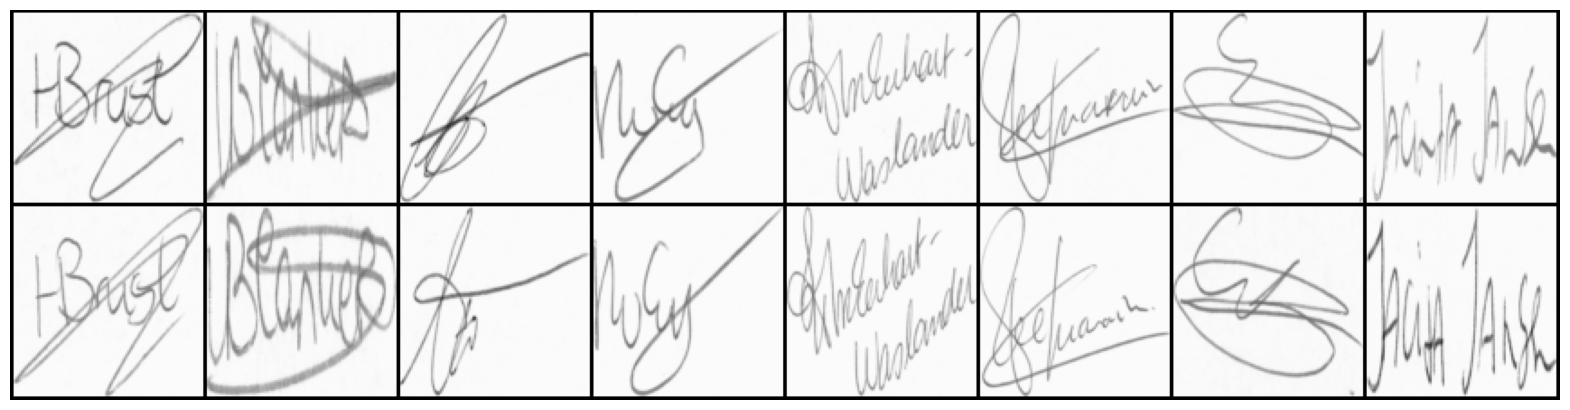

[ 1  1 -1  1  1  1  1 -1]


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, utils

# Viewing the sample of images to check whether its loading properly
print('"1" - real, "-1" - fake')

vis_dataset = SiameseNetworkDataset(
    "/content/sign_data_mini/train",
    transform=transforms.Compose(
        [
            transforms.Resize((105, 105)),
            transforms.ToTensor(),
        ]
    ),
)

vis_dataloader = DataLoader(vis_dataset, batch_size=8, shuffle=True)

example_batch = next(iter(vis_dataloader))  # images1, images2, labels
images1, images2, labels = example_batch
# display the data
concatenated = torch.cat((images1, images2), dim=0)
grid = torchvision.utils.make_grid(concatenated)

plt.figure(figsize=(20, 40))
plt.axis("off")

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()

print(labels.numpy())

Оценим баланс классов.

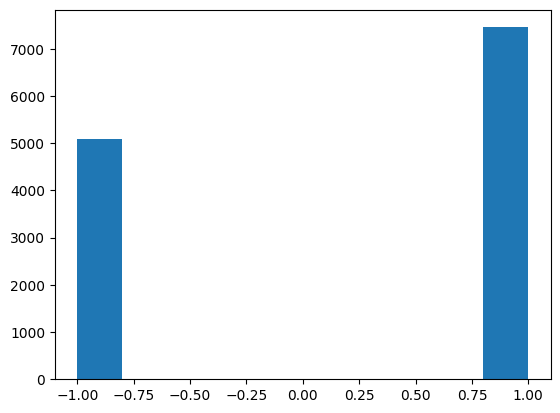

In [ ]:
# For check classes balance
plt.hist(vis_dataset.targets)
plt.show()

Создание тренировочного и тестового датасета и даталоадера.

В отличие от даталоадера для визуализации, к трансформациям добавилась нормализация.

Этот блок можно модифицировать.

In [ ]:
# Define transforms include Normalization
transform = transforms.Compose(
    [
        transforms.Resize((105, 105)),
        transforms.ToTensor(),
        transforms.Normalize(0.9409, 0.1078),
    ]
)

# Load the dataset as pytorch tensors using dataloader
sign_train_dataset = SiameseNetworkDataset(
    dir="/content/sign_data_mini/train", transform=transform
)
sign_train_loader = DataLoader(sign_train_dataset, batch_size=128, shuffle=True, num_workers=1)

# Load the test dataset
sign_test_dataset = SiameseNetworkDataset(
    dir="/content/sign_data_mini/test", transform=transform
)
sign_test_loader = DataLoader(sign_test_dataset, batch_size=8, shuffle=False, num_workers=1)

## Создание сети

В данном блоке нужно описать структуру модели.

На вход модели поступают **два** одноканальных изображения, а не одно (метод `forward` получает `input1` и `input2`).

На выходе **два** вектора признаков (embeddings) `out1` и `out2`.

Размер embedding выберите произвольно, достаточно 32–64 компонент.

Допускается использовать в качестве основы готовые модели из torchvision или timm.

In [ ]:
!pip install -q timm

In [ ]:
import timm

In [ ]:
from torchvision.models import efficientnet_b0

In [ ]:
from torch import nn


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        # Your code here
        #self.model = efficientnet_b0()
        #self.model.classifier = nn.Linear(1280, embedding_dim)
        #self.model.features[0][0] = nn.Conv2d(
        #    1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        #)

        self.model = timm.create_model("resnet18.a1_in1k",
                                       num_classes=embedding_dim,
                                       pretrained=False)

        # Because we use grayscale images reduce input channel count to one
        # and reduce kernel_size to process images smaller than ImageNet
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )


    def forward(self, input1, input2):
        # Your code here
        out1 = torch.nn.functional.normalize(self.model(input1))
        out2 = torch.nn.functional.normalize(self.model(input2))

        return out1, out2


model = SiameseNetwork()

## Метрика

Вспомогательный метод `emb2pred` служит для расчета косинусной схожести между двумя эмбеддингами и отнесения данной пары к классу $0$ или $1$ в зависимости от порога `threshold`.

Пара подписей считаются принадлежащими одному человеку, если косинусное сходство между их эмбеддингами больше порога. Иначе одна из подписей считается подделкой.

In [ ]:
from torch.nn.functional import cosine_similarity


def emb2pred(emb1, emb2, threshold):
    sim = cosine_similarity(emb1, emb2)
    pred = torch.empty_like(sim)
    pred[sim < threshold] = 0   # Forged, not "-1" as in dataset for metric compute
    pred[sim >= threshold] = 1  # Original
    return pred

Теперь можно считать метрику качества. В качестве метрики воспользуемся F1-score из torchmetrics. Убедимся, что на необученной модели она будет низкой.

Для метрик бинарной классификации в torchmetrics ожидается, что метки классов принадлежат $\{0, 1\}$. Поэтому функция `emb2pred` выдает $0$ или $1$ в зависимости от порога, а метки $-1$ из датасета заменяются на $0$.

In [ ]:
!pip install -q torchmetrics

In [ ]:
import torchmetrics

metric = torchmetrics.classification.BinaryF1Score()

model.eval()

for batch in sign_test_loader:
    images1, images2, labels = batch
    emb1, emb2 = model(images1, images2)

    preds = emb2pred(emb1, emb2, threshold=0.5)
    labels[labels==-1] = 0  # for metric computation
    metric.update(preds, labels)

print(metric.compute().item())
metric.reset()

0.6734693646430969


## Обучение

Блок кода для обучения. В качестве лосс-функции предлагается воспользоваться [`torch.nn.CosineEmbeddingLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html).

Обратите внимание на то, [что эта лосс-функция принимает при расчете](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html#:~:text=Default%3A%20%27mean%27-,Shape%3A,-Input1%3A):
* батч эмбеддингов №1
* батч эмбеддингов №2
* батч меток классов, состоящий из $1$ и $-1$


In [ ]:
def emb2pred2(emb1, emb2, threshold):
    sim = cosine_similarity(emb1, emb2)
    pred = torch.empty_like(sim)
    pred[sim < threshold] = -1
    pred[sim >= threshold] = 1  # Original
    return pred

In [ ]:
!pip install -q lightning

In [ ]:
import lightning as L
import torchmetrics

import torch.nn.functional as F


class LitSiamese(L.LightningModule):
    def __init__(self, model, threshold=0.5):
        super().__init__()
        self.model = model
        self.threshold = threshold

        self.criterion = nn.CosineEmbeddingLoss() # Your code here

        self.train_metric = torchmetrics.classification.BinaryF1Score()
        self.val_metric = torchmetrics.classification.BinaryF1Score()
        self.test_metric = torchmetrics.classification.BinaryF1Score()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters())

    def training_step(self, batch, batch_idx):
        # 1. unpack batch
        # Your code here
        inp1, inp2, labels = batch

        # 2. do forward through model and loss, logging loss
        # Your code here
        out1, out2 = self.model(inp1, inp2)
        loss = self.criterion(out1, out2, labels)

        self.log("train_loss", loss)

        # 3. get {0, 1} predictions with self.threshold,
        #    change "-1" labels to "0" and update train_metric
        # Your code here
        preds = emb2pred(out1, out2, self.threshold)
        labels[labels==-1] = 0  # for metric computation
        self.train_metric.update(preds, labels)

        return loss

    def on_train_epoch_end(self):
        # compute metric and do metric logging, reset train_metric
        # Your code here
        self.train_metric.compute()
        self.train_metric.reset()

    def validation_step(self, batch, batch_idx):
        # all the same steps as in training_step
        # but without `return loss`
        # Your code here
        inp1, inp2, labels = batch

        # 2. do forward through model and loss, logging loss
        # Your code here
        out1, out2 = self.model(inp1, inp2)
        loss = self.criterion(out1, out2, labels)

        self.log("val_loss", loss)

        # 3. get {0, 1} predictions with self.threshold,
        #    change "-1" labels to "0" and update val_metric
        # Your code here
        preds = emb2pred(out1, out2, self.threshold)
        labels[labels==-1] = 0  # for metric computation
        self.val_metric.update(preds, labels)


    def on_validation_epoch_end(self):
        # all the same as in on_train_epoch_end
        print(self.val_metric.compute())
        self.val_metric.reset()

    def on_test_epoch_start(self):
        # initialise test results dict, nothing to change here
        self.test_similarity_dict = {"similarity": [], "true_label": []}

    def test_step(self, batch, batch_idx):
        # 1. unpack batch
        # Your code here
        inp1, inp2, labels = batch

        # 2. do forward through model
        # Your code here
        out1, out2 = self.model(inp1, inp2)

        # 3. accumulating test results dict in order to get similarity distributions
        #    (nothing to change here)
        cosine_sim = F.cosine_similarity(out1, out2)
        for i in range(labels.shape[0]):
            self.test_similarity_dict["similarity"].append(cosine_sim[i].item())
            self.test_similarity_dict["true_label"].append(labels[i].item())

        # 4. get {0, 1} predictions with self.threshold,
        #    change "-1" labels to "0" and update test_metric
        # Your code here
        preds = emb2pred(out1, out2, self.threshold)
        labels[labels==-1] = 0  # for metric computation
        self.test_metric.update(preds, labels)


    def on_test_epoch_end(self):
        # compute and print test_metric value, reset test_metric
        # Your code here
        print(self.test_metric.compute())
        self.test_metric.reset()

    def forward(self, input1, input2):
        # implement forward in lightning model to use it directly, nothing to change here
        return self.model(input1, input2)


Для сохранения модели на промежуточных эпохах и для возможности последующего возврата к лучшей модели воспользуемся `ModelCheckpoint`.

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    save_last=False,
    every_n_epochs=1,
    save_top_k=-1,
    save_weights_only=True,
    monitor="val_loss",
    filename="model-{epoch}-{val_loss:.4f}",
    mode="max",
)

Создание модели и запуск обучения. Достаточно 3 эпох.

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

L.seed_everything(42)

embedding_dim = 32
pl_model = LitSiamese(SiameseNetwork(embedding_dim))

logger = TensorBoardLogger(save_dir="lightning_logs", name="task5_SiameseNetwork")
trainer = L.Trainer(max_epochs=3, logger=logger, log_every_n_steps=1, callbacks=[checkpoint_callback])

trainer.fit(pl_model, sign_train_loader, sign_test_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type                | Params
-----------------------------------------------------
0 | model        | SiameseNetwork      | 11.2 M
1 | criterion    | CosineEmbeddingLoss | 0     
2 | train_metric | BinaryF1Score       | 0     
3 | val_metric   | BinaryF1Score       | 0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


tensor(0.8148, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.7664, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.8605, device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


tensor(0.8568, device='cuda:0')


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

## Тестирование

Вспомогательный код для вывода изображений

In [ ]:
def imshow(img, text=None):
    npimg = (
        img * 0.1078 + 0.9409
    ).numpy()  # canceling transforms.Normalize(0.9409, 0.1078)
    plt.figure(figsize=(5, 3))
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (10, 20)
    if text:
        plt.text(
            110,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Визуализация результатов сравнения на одном батче тестовой выборки

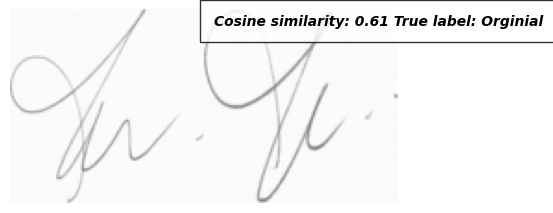

Cosine similarity  0.61 (range [-1 .. 1])


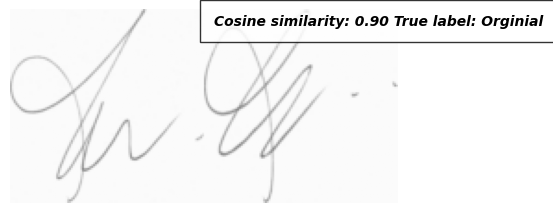

Cosine similarity  0.90 (range [-1 .. 1])


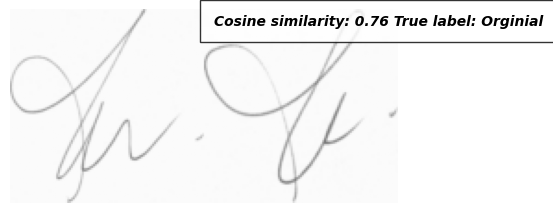

Cosine similarity  0.76 (range [-1 .. 1])


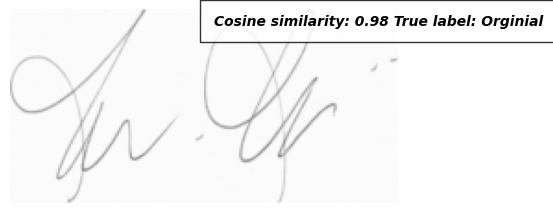

Cosine similarity  0.98 (range [-1 .. 1])


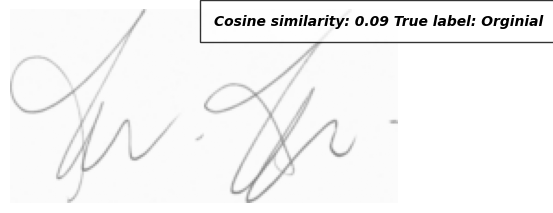

Cosine similarity  0.09 (range [-1 .. 1])


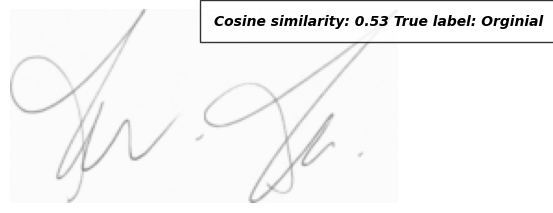

Cosine similarity  0.53 (range [-1 .. 1])


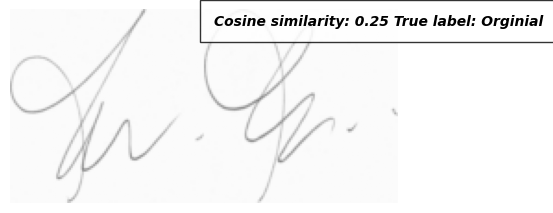

Cosine similarity  0.25 (range [-1 .. 1])


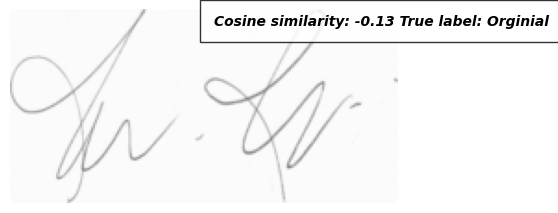

Cosine similarity  -0.13 (range [-1 .. 1])


In [ ]:
import torch.nn.functional as F

# Print the sample outputs to view its ssimilarity
batch = next(iter(sign_test_loader))

images1, images2, labels = batch
emb1, emb2 = pl_model(images1, images2)

cosine_sim = F.cosine_similarity(emb1, emb2)

for i in range(labels.shape[0]):
    concatenated = torch.cat((images1[i][0], images2[i][0]), 1)
    label = sign_test_dataset.classes[labels[i].item()]
    imshow(
        torchvision.utils.make_grid(concatenated),
        "Cosine similarity: {:.2f} True label: {}".format(
            cosine_sim[i].item(),
            label,
        ),
    )

    print(f"Cosine similarity  {cosine_sim[i].item():.2f} (range [-1 .. 1])")

Посмотрим на распределение схожести (Cosine Similarity) на изображениях тестовой выборки в разрезе по истинным классам.

Для этого запустим тестирование модели. После тестирования у модели появится атрибут `.test_similarity_dict`, который будет содержать величину косинусной схожести для каждой из пар изображений в тестовой выборке, а также метку класса для данной пары.

In [ ]:
trainer.test(dataloaders=sign_test_loader, ckpt_path="best")

INFO: Restoring states from the checkpoint path at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Testing: |          | 0/? [00:00<?, ?it/s]

tensor(0.7664, device='cuda:0')


[{}]

Отобразим распределения схожестей для тестовых пар в разрезе по метке класса.

similarity  true_label     label
0      0.971273           1  Orginial
1      0.998481           1  Orginial
2      0.981495           1  Orginial
3      0.980357           1  Orginial
4      0.897266           1  Orginial
..          ...         ...       ...
775    0.442226          -1    Forged
776    0.874809          -1    Forged
777    0.455902          -1    Forged
778    0.696144          -1    Forged
779    0.650501          -1    Forged

[780 rows x 3 columns]

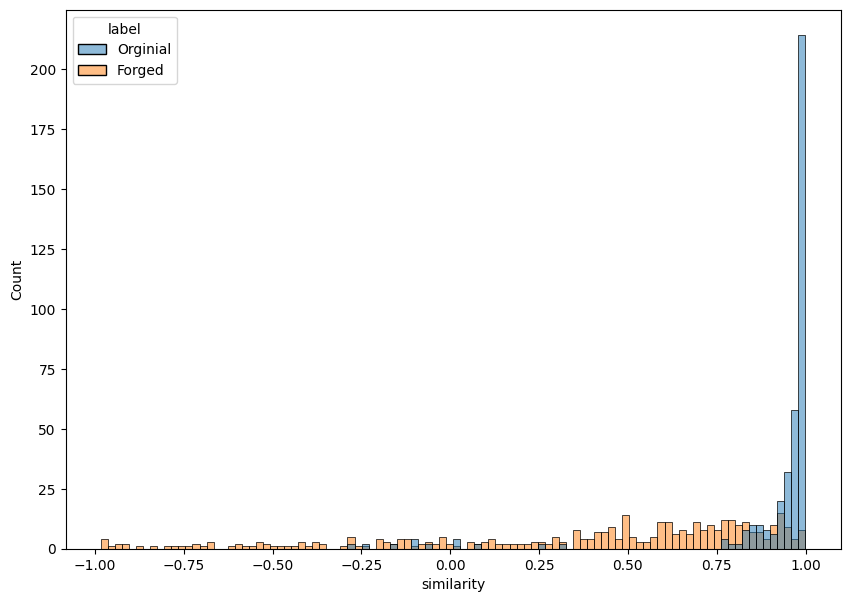

In [ ]:
test_results = pl_model.test_similarity_dict

sim_df = pd.DataFrame(test_results)
sim_df['label'] = sim_df['true_label'].map(sign_test_dataset.classes)
display(sim_df)

plt.figure(figsize=(10, 7))
sns.histplot(sim_df, x="similarity", hue="label", bins=100)
plt.show()

Какой порог косинусной схожести лучше выбрать, чтобы отличать оригинальные и поддельные подписи?

***Your text here***
На мой взгляд, такой порог, при котором число определенных оригиналов начинает превышать число подделок. Этот порог должен быть не слишком низким, т.к. подделанная подпись, при ее распознавании как оригинал, может привести к большим проблемам для человека-носителя оригинала. Но порог также должен быть и не слишком близким к единице, т.к. от раза к разу человек исполняет подпись немного по-разному.

Судя по гистограмме, можно взять порог 0.9


Финальная оценка точности с выбранным порогом:

In [ ]:
pl_model.threshold = 0.9 # Your value here
trainer.test(dataloaders=sign_test_loader, ckpt_path="best")

INFO: Restoring states from the checkpoint path at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at lightning_logs/task5_SiameseNetwork/version_2/checkpoints/model-epoch=0-val_loss=0.2883.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

tensor(0.8549, device='cuda:0')


[{}]

## Формат результата

* Реализованный код обучения сиамской сети
* Результаты обучения
* Оценка метрики качества на тестовой выборки больше 0.8